# D212 - Dimensionality Reduction Methods

In [1]:
## Import libraries/packages
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, warnings
sns.set_palette('colorblind')
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['figure.max_open_warning'] = False
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Data Preparation
---

In [2]:
## Import Data
df = pd.read_csv('churn_clean.csv')

In [3]:
## Isolate churn and continuous variables
keep = []
for col in df.columns:
    if df[col].dtype == float:
        keep.append(col)
df = df[keep]

In [4]:
## Drop location columns
df.drop(['Lat', 'Lng',], axis=1, inplace=True)

In [5]:
## Review reduced dataset
df

,Income,Outage_sec_perweek,Tenure,MonthlyCharge,Bandwidth_GB_Year
0,28561.99,7.978323,6.795513,172.455519,904.536110
1,21704.77,11.699080,1.156681,242.632554,800.982766
2,9609.57,10.752800,15.754144,159.947583,2054.706961
3,18925.23,14.913540,17.087227,119.956840,2164.579412
4,40074.19,8.147417,1.670972,149.948316,271.493436
...,...,...,...,...,...
9995,55723.74,9.415935,68.197130,159.979400,6511.252601
9996,34129.34,6.740547,61.040370,207.481100,5695.951810
9997,45983.43,6.590911,47.416890,169.974100,4159.305799
9998,16667.58,12.071910,71.095600,252.624000,6468.456752


In [6]:
## Scale the data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [7]:
## Review scaled dataset
scaled_df

,Income,Outage_sec_perweek,Tenure,MonthlyCharge,Bandwidth_GB_Year
0,-0.398778,-0.679978,-1.048746,-0.003943,-1.138487
1,-0.641954,0.570331,-1.262001,1.630326,-1.185876
2,-1.070885,0.252347,-0.709940,-0.295225,-0.612138
3,-0.740525,1.650506,-0.659524,-1.226521,-0.561857
4,0.009478,-0.623156,-1.242551,-0.528086,-1.428184
...,...,...,...,...,...
9995,0.564456,-0.196888,1.273401,-0.294484,1.427298
9996,-0.201344,-1.095915,1.002740,0.811726,1.054194
9997,0.219037,-1.146198,0.487513,-0.061729,0.350984
9998,-0.820588,0.695616,1.383018,1.863005,1.407713


In [8]:
## Store cleaned data
scaled_df.to_csv('clean_dataset.csv')

## Data Analysis
---

In [9]:
## Fit the data to PCA
pca = PCA(random_state=10)
pca.fit(scaled_df)

PCA(random_state=10)

In [10]:
## Determine the matrix of all the principal components
labels = []
for i in range(1, len(scaled_df.columns)+1):
    labels.append(f'PC{i}')
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_), index=df.columns, columns=labels)
loadings

,PC1,PC2,PC3,PC4,PC5
Income,0.005557,0.370087,0.896223,0.244723,-0.000100
Outage_sec_perweek,0.008271,-0.691154,0.077987,0.718510,0.000003
Tenure,0.996562,0.040454,-0.030029,0.034783,-0.056711
MonthlyCharge,0.057530,-0.638699,0.433013,-0.633515,-0.003645
Bandwidth_GB_Year,0.998419,0.000090,-0.000612,-0.005528,0.056816


In [11]:
## Get the explained variance
variance = pd.DataFrame(pca.explained_variance_, index=labels, columns=['Explained Variance'])
variance['% Explained Variance'] = (variance['Explained Variance'] / 5) * 100
variance

,Explained Variance,% Explained Variance
PC1,1.993386,39.867717
PC2,1.024231,20.484622
PC3,0.997699,19.953982
PC4,0.978727,19.574532
PC5,0.006457,0.129148


In [12]:
## Calculate the cumulative explained variance for each component
total_variance = np.sum(pca.explained_variance_ratio_[:2]) * 100
print(f'Total Variance: {round(total_variance, 2)}%')

Total Variance: 60.35%


In [13]:
## Store component variance in dataframe
total_variance = pd.DataFrame(
    [np.cumsum(pca.explained_variance_ratio_)], 
    index=['Explained Variance'], 
    columns=range(1,6)
).transpose()
total_variance

,Explained Variance
1,0.398637
2,0.603463
3,0.802983
4,0.998709
5,1.000000


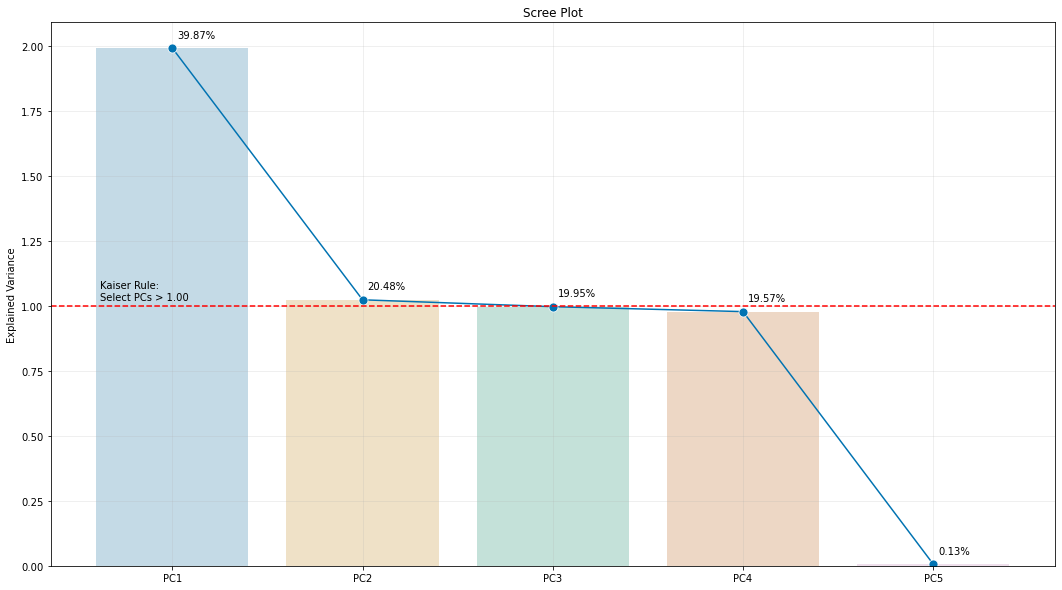

In [14]:
## Identify total number of PCs using the elbow rule
sns.barplot(x=variance.index, y=variance['Explained Variance'], alpha=0.25)
sns.lineplot(x=variance.index, y=variance['Explained Variance'], marker='o', markersize=9)
plt.title('Scree Plot')
plt.xticks(range(len(variance)), variance.index)

plt.axhline(y=1, color='red', ls='--')
plt.text(x=-0.38, y=1.025, s='Kaiser Rule:\nSelect PCs > 1.00')

for i in range(len(variance)):
    plt.text(
        x=i+0.025, 
        y=variance['Explained Variance'][i]+0.04, 
        s=('{}%').format(round(variance['% Explained Variance'][i], 2))
    )
plt.grid(alpha=0.25)

In [15]:
## Perform pca using the identified PCs
pca1 = PCA(n_components=2, random_state=10)
transformed_df = pd.DataFrame(pca1.fit_transform(scaled_df), columns=['PC1', 'PC2'])
transformed_df

,PC1,PC2
0,-1.551056,0.279016
1,-1.662133,-1.703695
2,-0.948752,-0.406056
3,-0.906067,-0.650333
4,-1.912132,0.712517
...,...,...
9995,1.897218,0.577749
9996,1.479124,0.202701
9997,0.583942,0.921346
9998,2.048431,-1.895463


Text(0.7601962680126577, -0.12491148128949248, 'Bandwidth_GB_Year')

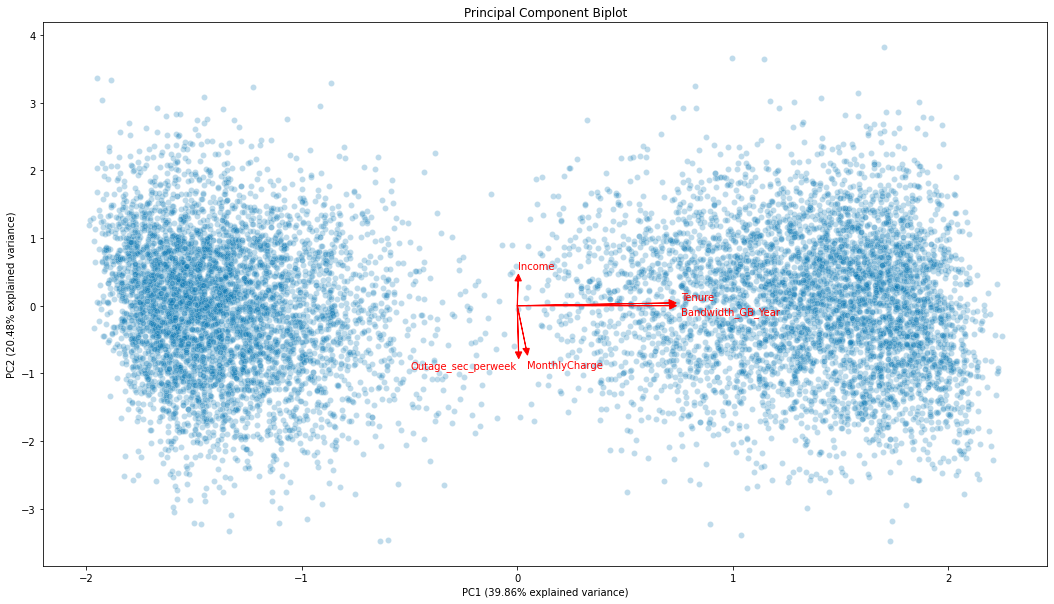

In [16]:
## Plot pca results and original loadings
sns.scatterplot(x='PC1', y='PC2', data=transformed_df, alpha=0.25)
plt.title('Principal Component Biplot')
plt.xlabel(f'PC1 ({pca1.explained_variance_ratio_[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({pca1.explained_variance_ratio_[1]:.2%} explained variance)')

loadings = pca.components_.T
plt.arrow(0, 0, loadings[0, 0], loadings[0, 1], head_width=0.03, head_length=0.1, linewidth=1, color='r')
plt.text(loadings[0, 0], loadings[0, 1] * 1.5, df.columns[0], color='r', fontsize=10)
plt.arrow(0, 0, loadings[1, 0], loadings[1, 1], head_width=0.03, head_length=0.1, linewidth=1, color='r')
plt.text(loadings[1, 0] - 0.5, loadings[1, 1] * 1.35, df.columns[1], color='r', fontsize=10)
plt.arrow(0, 0, loadings[2, 0], loadings[2, 1], head_width=0.1, head_length=0.031, linewidth=1, color='r')
plt.text(loadings[2, 0] * 1.075, loadings[2, 1] + 0.05, df.columns[2], color='r', fontsize=10)
plt.arrow(0, 0, loadings[3, 0], loadings[3, 1], head_width=0.03, head_length=0.1, linewidth=1, color='r')
plt.text(loadings[3, 0] * 1.1, loadings[3, 1] * 1.45, df.columns[3], color='r', fontsize=10)
plt.arrow(0, 0, loadings[4, 0], loadings[4, 1], head_width=0.1, head_length=0.031, linewidth=1, color='r')
plt.text(loadings[4, 0] * 1.075, loadings[4, 1] - 0.125, df.columns[4], color='r', fontsize=10)